In [32]:
#Celda para librerías
import sklearn as sk

import matplotlib as plt
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np
import plotly.graph_objects as go


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler


# LightGBM
from lightgbm import LGBMClassifier
import lightgbm as lgb

#KGBoost
from xgboost import XGBClassifier
#KNN
from sklearn.neighbors import KNeighborsClassifier
#Neural Network
from sklearn.neural_network import MLPClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier


from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score


import json

import warnings
warnings.filterwarnings('ignore')

print(np.__version__)
from ydata_profiling import ProfileReport
import os
print("Directorio actual:", os.getcwd())



# Have all columns appear when dataframes are displayed.
pd.set_option('display.max_columns', None) 
# Have 100 rows appear when a dataframe is displayed
pd.set_option('display.max_rows', 500)
# Display dimensions whenever a dataframe is printed out.
pd.set_option('display.show_dimensions', True)


#Importando los datos

app_train = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/application_train.csv')
app_test = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/application_test.csv')
"""
bureau = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/bureau_balance.csv')
credit_card_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/credit_card_balance.csv')
installments_payments = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/installments_payments.csv')
pos_cash_balance = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/POS_CASH_balance.csv')
previous_application = pd.read_csv(r'C:/Users/Yeray/Desktop/DATA_SCIENCE_ML/Home-Credit-TFG/DATA/home-credit-default-risk/previous_application.csv')
"""
app_train.drop(columns=['SK_ID_CURR'], inplace=True)
#info = app_train.info()
#print(info)
#describe = app_train.describe()

1.23.5
Directorio actual: c:\Users\Yeray\Desktop\DATA_SCIENCE_ML\Home-Credit-TFG\JUPYTER_NOTEBOOKS


In [2]:
#Feature Engineering

#Debido a un fallo que detecta que todas los valores de la columna DAYS_BIRTH 
# son nan cuando no es así, vamos a sustituir la columna por una nueva llamada AGE_INT
app_train['AGE_INT'] = app_train['DAYS_BIRTH']/-365
app_train.drop(columns=['DAYS_BIRTH'], inplace=True)


#Vamos a convertir la variable CNT_CHILDREN en una variable categórica que indique 1 si tiene hijos y 0 si no.
app_train['HAS_CHILDREN'] = np.where(app_train['CNT_CHILDREN'] > 0, 1, 0)
app_train.drop(columns=['CNT_CHILDREN'], inplace=True)
#Vamos a crear la variable DAYS_EMPLOYED en una variable categórica que indique 1 si tiene empleo y 0 si no.
app_train['HAS_EMPLOYMENT'] = app_train['DAYS_EMPLOYED'].map(lambda x: 1 if x < 0 else 0)

#Voy a crear RATIOS para algunas de las variables más importantes (en mi opinión) y que además tienen valores atípicos.
app_train['CREDIT_AMT_INCOME_RATIO'] = app_train['AMT_CREDIT']/app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_AMT_INCOME_RATIO'] = app_train['AMT_ANNUITY']/app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_ANNUITY_RATIO'] = app_train['AMT_CREDIT']/app_train['AMT_ANNUITY']
app_train['CREDIT_GOODS_PRICE_RATIO'] = app_train['AMT_CREDIT']/app_train['AMT_GOODS_PRICE']
app_train['GOODS_INCOME_RATIO'] = app_train['AMT_GOODS_PRICE']/app_train['AMT_INCOME_TOTAL']


#EXT_SOURCE son variables representan fuentes externas de información sobre el cliente, y suelen estar relacionadas con puntuaciones de riesgo crediticio generadas por 
# instituciones externas al prestamista, como burós de crédito u otras entidades que evalúan el perfil financiero de los clientes.
#Vamos a crear variables relacionadas con EXT_SOURCE.

app_train['EXT_SOURCE_SUM'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1)
app_train['EXT_SOURCE_MEAN'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
app_train['EXT_SOURCE_MEDIAN'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].median(axis=1)
app_train['EXT_SOURCE_MAX'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
app_train['EXT_SOURCE_MIN'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].min(axis=1)

app_train['EXT_SOURCE_WEIGHTED_SUM'] = app_train['EXT_SOURCE_1']*2 + app_train['EXT_SOURCE_2']*3 + app_train['EXT_SOURCE_3']*4
app_train['EXT_SOURCE_WEIGHTED_MEAN'] = (app_train['EXT_SOURCE_1']*2 + app_train['EXT_SOURCE_2']*3 + app_train['EXT_SOURCE_3']*4)/3


#Variables a partir de sumas y diferencias
app_train['CREDIT_BUREAU_TOTAL'] = app_train[['AMT_REQ_CREDIT_BUREAU_DAY', 
                                             'AMT_REQ_CREDIT_BUREAU_HOUR',
                                             'AMT_REQ_CREDIT_BUREAU_MON',
                                             'AMT_REQ_CREDIT_BUREAU_QRT',
                                             'AMT_REQ_CREDIT_BUREAU_WEEK',
                                             'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

app_train['CREDIT_GOODS_DIFF'] = app_train['AMT_CREDIT'] - app_train['AMT_GOODS_PRICE']
app_train['GOODS_ANNUITY_DIFF'] = app_train['AMT_ANNUITY'] - app_train['AMT_GOODS_PRICE']

app_train['SOCIAL_OBSERVATION_TOTAL'] = app_train['OBS_30_CNT_SOCIAL_CIRCLE'] + app_train['OBS_60_CNT_SOCIAL_CIRCLE']
app_train['SOCIAL_DEF_TOTAL'] = app_train['DEF_30_CNT_SOCIAL_CIRCLE'] + app_train['DEF_60_CNT_SOCIAL_CIRCLE']

app_train['DIFF_OBS_30_60'] = app_train['OBS_30_CNT_SOCIAL_CIRCLE'] - app_train['OBS_60_CNT_SOCIAL_CIRCLE']
app_train['DIFF_DEF_30_60'] = app_train['DEF_30_CNT_SOCIAL_CIRCLE'] - app_train['DEF_60_CNT_SOCIAL_CIRCLE']

In [3]:
education_mapping = {
    'No formal education': 0,
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
}
"""
income_type_mapping = {
    'Unemployed': 0,
    'Student': 1,
    'Pensioner': 2,
    'Maternity leave': 3,
    'Working': 4,
    'State servant': 5,
    'Commercial associate': 6,
    'Businessman': 7,    
}

family_mapping = {
    'Single / not married': 0,
    'Separated': 1,
    'Widow': 2,
    'Married': 3
}

housing_mapping = {
    'With parents': 0,
    'Municipal apartment': 1,
    'Rented apartment': 2,
    'House / apartment': 3
}


app_train['EDUCATION_LEVEL'] = app_train['NAME_EDUCATION_TYPE'].map(education_mapping)
app_train['INCOME_TYPE'] = app_train['NAME_INCOME_TYPE'].map(income_type_mapping)
app_train['FAMILY_STATUS'] = app_train['NAME_FAMILY_STATUS'].map(family_mapping)
app_train['HOUSING_TYPE'] = app_train['NAME_HOUSING_TYPE'].map(housing_mapping)

"""

"\nincome_type_mapping = {\n    'Unemployed': 0,\n    'Student': 1,\n    'Pensioner': 2,\n    'Maternity leave': 3,\n    'Working': 4,\n    'State servant': 5,\n    'Commercial associate': 6,\n    'Businessman': 7,    \n}\n\nfamily_mapping = {\n    'Single / not married': 0,\n    'Separated': 1,\n    'Widow': 2,\n    'Married': 3\n}\n\nhousing_mapping = {\n    'With parents': 0,\n    'Municipal apartment': 1,\n    'Rented apartment': 2,\n    'House / apartment': 3\n}\n\n\napp_train['EDUCATION_LEVEL'] = app_train['NAME_EDUCATION_TYPE'].map(education_mapping)\napp_train['INCOME_TYPE'] = app_train['NAME_INCOME_TYPE'].map(income_type_mapping)\napp_train['FAMILY_STATUS'] = app_train['NAME_FAMILY_STATUS'].map(family_mapping)\napp_train['HOUSING_TYPE'] = app_train['NAME_HOUSING_TYPE'].map(housing_mapping)\n\n"

In [4]:
# Preprocesamiento previo a la creación de los modelos
# Imputación de valores nulos. Vamos a probar de momento a completar variables numéricos con la media
# y las categóricas con la moda.
# Como sabemos que DAYS_EMPLOYEED tiene un valor erroneo, vamos a reemplazarlo por NaN
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
# Algunas variables categóricas tienen valores como XNA, vamos a reemplazarlos por NaN
def reemplazar_xna_por_nan(app_train):
    variables_categoricas = app_train.select_dtypes(include=['object']).columns
    for col in variables_categoricas:
        app_train[col] = app_train[col].replace('XNA', np.nan)
    return app_train
app_train_noxna = reemplazar_xna_por_nan(app_train)

app_train = reemplazar_xna_por_nan(app_train)
def imputar_valores_nulos(app_train):
    variables_continuas = app_train.select_dtypes(include=['int64', 'float64']).columns 
    for col in variables_continuas:
        app_train[col] = app_train[col].fillna(app_train[col].mean())
    variables_categoricas = app_train.select_dtypes(include=['object']).columns
    for col in variables_categoricas:
        app_train[col] = app_train[col].fillna(app_train[col].mode()[0])

    return app_train

app_train_nonan = imputar_valores_nulos(app_train_noxna)
#Comprobamos que no haya valores nulos
#print(app_train['DAYS_BIRTH'].unique())
#print(app_train['DAYS_BIRTH'].isnull().sum())
#print(app_train['DAYS_BIRTH'].dtype)

# Verificar si hay valores nulos en app_train después de la imputación
print("Valores nulos en app_train después de la imputación:")
print(app_train_nonan.isnull().sum().sum())

Valores nulos en app_train después de la imputación:
0


In [5]:
# Tratamiento de variables categóricas
# Vamos a probar con Label Encoding para las variables categoricas binarias y con 
# One Hot Encoding para el resto.

variables_categoricas = app_train.select_dtypes(include=['object']).columns
variables_categoricas_binarias = [col for col in variables_categoricas if app_train[col].nunique() == 2]
variables_categoricas_no_binarias = [col for col in variables_categoricas if app_train[col].nunique() > 2]
def label_encoding_binarias(app_train):
    Encoder = LabelEncoder()
    for col in variables_categoricas_binarias:
        app_train[col] = Encoder.fit_transform(app_train[col])
    return app_train

app_train_nonan_le = label_encoding_binarias(app_train_nonan)


def one_hot_encoding_no_binarrias(app_train):
    for col in variables_categoricas_no_binarias:
        app_train = pd.get_dummies(app_train, columns=[col])
    return app_train

app_train_nonan_le_oh = one_hot_encoding_no_binarrias(app_train_nonan_le)
print("Valores nulos en app_train después de la imputación:")
print(app_train_nonan_le_oh.isnull().sum().sum())



Valores nulos en app_train después de la imputación:
0


In [6]:
# Normalización de las variables
# Como gracias a la exploración de datos hemos visto que hay variables que ya han sido normalizadas 
# previamente, nos vamos a centrar en aquellas que necesitan ser normalizadas.
variables_continuas = app_train_nonan_le_oh.select_dtypes(include=['int64', 'float64']).columns
variables_normalizadas = [col for col in variables_continuas if
                          app_train[col].min() >= 0 and app_train[col].max() <= 1]
variables_NO_normalizadas = [col for col in variables_continuas if col not in variables_normalizadas]

# Vamos a probar con Log Transformation por el momento debido a que tienen bastantes valores atípicos
# log1p transforma los valores negativos en nan por lo que vamos a usar RobustScaler para evitarlo
scaler = RobustScaler()
#Voy a probar también con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
def normalización(app_train):
    for col in variables_NO_normalizadas:
        app_train[col] = scaler2.fit_transform(app_train[[col]])
    return app_train

app_train_nonan_le_oh_norm = normalización(app_train_nonan_le_oh)
print("Valores nulos en app_train después de la imputación:")
print(app_train_nonan_le_oh_norm.isnull().sum().sum())

Valores nulos en app_train después de la imputación:
0


In [7]:
#Tras este preprocesamiento inicial vamos a probar diferentes algoritmos. La métrica usada será AUC_ROC.
#Vamos a probar con los siguientes algoritmos:LightGBM, XGBoost, KNN, Neural Network y Random Forest
x = app_train_nonan_le_oh_norm.drop(columns=['TARGET'])
y = app_train_nonan_le_oh_norm['TARGET']

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

### Resultados de los modelos conforme he ido haceindo cambios
Arreglar markdown que en git aparece con formato erróneo.
#LightGBM
-LightGBM AUC: 0.7536 (Log Transformation)
-LightGBM AUC: 0.7576 (Robust Scaler)
-LightGBM AUC: 0.7577 (MinMax)
-LightGBM AUC: 0.7577 (Se me había pasado reemplazar algunos valores XNA en variables categóricas)
-LightGBM AUC: 0.7578 (Variable HAS_CHILDREN y HAS_EMPLOYMENT añadida. Variable CNT_CHILDREN eliminada)
-LightGBM AUC: 0.7664 (He creado 5 nuevas, RATIOS de algunas variables más "importantes")
-LightGBM AUC: 0.7654 (Tras añadir variables relacionadas con EXT_SOURCE)
-LightGBM AUC: 0.7650 (Nuevas variables en base a sumas y diferencias)
-LightGBM AUC: 0.7647 (EDUCATION_TYPE mapped)



Comienzo con la optimización de hiperparámetros
-Mejor AUC-ROC: 0.7623980960350135

He usado un space reducido de primeras solo con space = {
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -1),  # Valores entre e^(-5) y e^(-1)
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1.0)
}

Y los mejores resultados obtenidos han sido: {'feature_fraction': 0.5272194081485266, 'learning_rate': 0.007956692977969942, 'min_child_samples': 95, 'n_estimators': 950, 'num_leaves': 146}

-AUC-ROC del modelo LightGBM optimizado:  0.7697397208645272 
-AUC-ROC del modelo LightGBM optimizado con mejores parámetros:  0.7696052052611496

-AUC-ROC del modelo LightGBM optimizado con nuevos parámetros:  0.7700592619675601

-Descartes
-LightGBM AUC: 0.7656 (Codificación numérica apropiada para algunas variables) (Voy a descartar la idea por el momento porque me ha dado peores resultados todos los modelos)

#XGBoost
-XGBoost AUC: 0.7491
-XGBoost AUC: 0.7481
-XGBoost AUC: 0.7481
-XGBoost AUC: 0.7488
-XGBoost AUC: 0.7491
-XGBoost AUC: 0.7599
-XGBoost AUC: 0.7588
-XGBoost AUC: 0.7578
-XGBoost AUC: 0.7589

-Mejor AUC-ROC: 0.7634494411242914

#Random Forest
-Random Forest AUC: 0.7068
-Random Forest AUC: 0.7136
-Random Forest AUC: 0.7138
-Random Forest AUC: 0.7154
-Random Forest AUC: 0.7097
-Random Forest AUC: 0.7152
-Random Forest AUC: 0.7236
-Random Forest AUC: 0.7235
-Random Forest AUC: 0.7258

#Extra Trees
-Extra Trees AUC: 0.6981
-Extra Trees AUC: 0.7052
-Extra Trees AUC: 0.7048
-Extra Trees AUC: 0.7038
-Extra Trees AUC: 0.7053
-Extra Trees AUC: 0.7077
-Extra Trees AUC: 0.7262
-Extra Trees AUC: 0.7204
-Extra Trees AUC: 0.7241

#Logistic Regresion
-Logistic Regression AUC: 0.7417
-Logistic Regression AUC: 0.7478
-Logistic Regression AUC: 0.7457
-Logistic Regression AUC: 0.7452
-Logistic Regression AUC: 0.7459
-Logistic Regression AUC: 0.7480
-Logistic Regression AUC: 0.7497
-Logistic Regression AUC: 0.7500
-Logistic Regression AUC: 0.7501

#Neural Network
-Neural Network AUC: 0.6861
-Neural Network AUC: 0.7437 (Como la primera vez tardó demasiado lo descarté, pero tras el último cambio, Variable HAS_CHILDREN y HAS_EMPLOYMENT añadida, he probado a ejecutarla e interrumpirla pronto y me ha dado un buen resultado)

#Modelos descartados

#KNN (He decidido no seguir haciendo pruebas con KNN. En comparación con los otros modelos los resultados son más bajos y cada vez que refino el proceso empeora)
-KNN AUC: 0.5482
-KNN AUC: 0.5575
-KNN AUC: 0.5497
-KNN AUC: 0.5471





In [22]:
space = {
    'num_leaves': hp.quniform('num_leaves', 130, 160, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.01)),
    'n_estimators': hp.quniform('n_estimators', 900, 1000, 50),
    'min_child_samples': hp.quniform('min_child_samples', 90, 100, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.6),
    # Nuevos parámetros
    'max_depth': hp.quniform('max_depth', 10, 20, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.6, 1.0),
    'lambda_l1': hp.loguniform('lambda_l1', -4, 0),
    'lambda_l2': hp.loguniform('lambda_l2', -4, 0)
    
}


#Vamos a buscar ahora los mejores hiperparámetros

trials = Trials()

In [23]:
def objective(params):
    #Convierto los hiperparámetros en enteros si es necesario
    params['learning_rate'] = max(params['learning_rate'], 1e-3)
    params['num_leaves'] = int(params['num_leaves'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_samples'] = int(params['min_child_samples'])
    params['max_depth'] = int(params['max_depth'])
    

    #Modelo para parametros actuales
    model = LGBMClassifier(
        num_leaves=params['num_leaves'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        min_child_samples=params['min_child_samples'],
        feature_fraction=params['feature_fraction'],
        max_depth=params['max_depth'],
        bagging_fraction=params['bagging_fraction'],
        lambda_l1=params['lambda_l1'],
        lambda_l2=params['lambda_l2'],
        random_state=42
    )

    auc = cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=3).mean() 
    #Como hyperopt minimiza la función objetivo, devolvemos el negativo de la métrica
    return {'loss': -auc, 'status': STATUS_OK}


In [24]:
best = fmin(
    fn=objective, #Función objetivo
    space=space, #Espacio de búsqueda
    algo=tpe.suggest, #Algoritmo TPE
    max_evals=50, #Número de evaluaciones
    trials=trials, #Almacenamiento de resultados
    rstate= np.random.default_rng(42) #Reproducibilidad
)

#Convertimos los resultados a su formato original

best['num_leaves'] = int(best['num_leaves'])
best['n_estimators'] = int(best['n_estimators'])
best['min_child_samples'] = int(best['min_child_samples'])
best['max_depth'] = int(best['max_depth'])

print("Mejores hiperparámetros: ", best)

[LightGBM] [Warning] feature_fraction is set=0.5323999035715434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5323999035715434
[LightGBM] [Warning] lambda_l1 is set=0.32053424375240913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32053424375240913
[LightGBM] [Warning] lambda_l2 is set=0.028873965683529606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028873965683529606
[LightGBM] [Warning] bagging_fraction is set=0.7936739623353964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7936739623353964
[LightGBM] [Warning] feature_fraction is set=0.5323999035715434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5323999035715434
[LightGBM] [Warning] lambda_l1 is set=0.32053424375240913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.32053424375240913
[LightGBM] [Warning] lambda_l2 is set=0.028873965683529606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028873965683529606

In [29]:
import pickle
#Cargar los mejores valores sin tener que recalcularlos
with open("best_params_lightgbm.json", "r") as f:
    best = json.load(f)
with open("trials_lightgbm.pkl", "rb") as f:
    trials = pickle.load(f)

In [25]:
#Entrenamos el modelo con los mejores hiperparámetros
model_optimizado = LGBMClassifier(
    num_leaves=best['num_leaves'],
    learning_rate=best['learning_rate'],
    n_estimators=best['n_estimators'],
    min_child_samples=best['min_child_samples'],
    feature_fraction=best['feature_fraction'],
    max_depth=best['max_depth'],z
    bagging_fraction=best['bagging_fraction'],
    lambda_l1=best['lambda_l1'],
    lambda_l2=best['lambda_l2'],
    random_state=42
)

model_optimizado.fit(X_train, Y_train)
auc_roc = roc_auc_score(Y_test, model_optimizado.predict_proba(X_test)[:,1])
print("AUC-ROC del modelo LightGBM optimizado con nuevos parámetros: ", auc_roc)

[LightGBM] [Warning] feature_fraction is set=0.5581958018415015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581958018415015
[LightGBM] [Warning] lambda_l1 is set=0.9121582084701998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9121582084701998
[LightGBM] [Warning] lambda_l2 is set=0.10987633283769352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10987633283769352
[LightGBM] [Warning] bagging_fraction is set=0.9064040676268638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9064040676268638
[LightGBM] [Warning] feature_fraction is set=0.5581958018415015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581958018415015
[LightGBM] [Warning] lambda_l1 is set=0.9121582084701998, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9121582084701998
[LightGBM] [Warning] lambda_l2 is set=0.10987633283769352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10987633283769352
[LightG

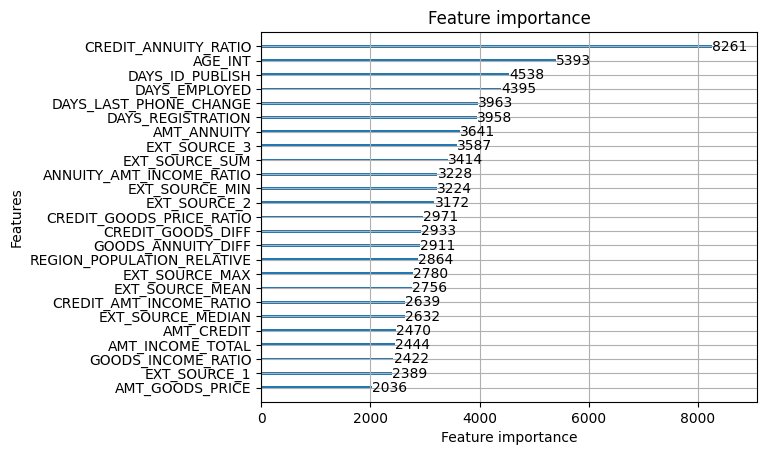

In [37]:
#Vamos a ver la importancia de las variables en el modelo para sacar ideas de cara al feature engineering
lgb.plot_importance(model_optimizado, max_num_features=25)
plt.show()

In [30]:
#Optimización de hiperparámetros con XGBoost
space_xgb = {
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 10),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.loguniform('gamma', 0, 5),
    'reg_alpha': hp.loguniform('reg_alpha', -3, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -3, 2)
    }

In [31]:
def objective_xgb(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])


    model_xgb = XGBClassifier(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        use_label_encoder=False,
        random_state=42,
        eval_metric='auc'
    )

    score = cross_val_score(model_xgb, X_train, Y_train, scoring='roc_auc', cv=3).mean()

    return {'loss': -score, 'status': STATUS_OK}

In [ ]:
best_xgb = fmin(
    fn=objective_xgb,
    space=space_xgb,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
    rstate= np.random.default_rng(42)
)

best_xgb['max_depth'] = int(best_xgb['max_depth'])
best_xgb['n_estimators'] = int(best_xgb['n_estimators'])
best_xgb['min_child_weight'] = int(best_xgb['min_child_weight'])
print("Mejores hiperparámetros: ", best_xgb)

In [ ]:
model_optimizado_xgb = XGBClassifier(
    max_depth=best_xgb['max_depth'],
    learning_rate=best_xgb['learning_rate'],
    n_estimators=best_xgb['n_estimators'],
    min_child_weight=best_xgb['min_child_weight'],
    subsample=best_xgb['subsample'],
    colsample_bytree=best_xgb['colsample_bytree'],
    gamma=best_xgb['gamma'],
    reg_alpha=best_xgb['reg_alpha'],
    reg_lambda=best_xgb['reg_lambda'],
    use_label_encoder=False,
    random_state=42,
    eval_metric='auc'
)

model_optimizado_xgb.fit(X_train, Y_train)
auc_roc_xgb = roc_auc_score(Y_test, model_optimizado_xgb.predict_proba(X_test)[:,1])
print("AUC-ROC del modelo XGBoost optimizado con nuevos parámetros: ", auc_roc_xgb)


In [14]:
#LightGBM
from sklearn.model_selection import RandomizedSearchCV

# Remove special characters from column names
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

param_dist = {
    'num_leaves':[20,31,40,50],
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[100,200,300],
    'min_child_samples':[10,20,30],
    'feature_fraction':[0.6,0.8,1],
    }

lgb_model = LGBMClassifier(random_state=42)

lgb_random_search = RandomizedSearchCV(estimator=lgb_model, 
                                       param_distributions=param_dist,
                                       n_iter=20,
                                       scoring='roc_auc',
                                       cv=3,
                                       verbose=1,
                                       random_state=42)

lgb_random_search.fit(X_train, Y_train)

#Evaluación
print("Mejores parámetros:", lgb_random_search.best_params_)
print("Mejor AUC-ROC:", lgb_random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 13251, number of negative: 150754
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15070
[LightGBM] [Info] Number of data points in the train set: 164005, number of used features: 247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080796 -> initscore=-2.431576
[LightGBM] [Info] Start training from score -2.431576
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.

In [15]:
#XGBoost

param_dist = {
    'max_depth':[3,5,7,9],
    'learning_rate':[0.01,0.05,0.1],
    'n_estimators':[100,200,300],
    'subsample':[0.6,0.8,1],
    'colsample_bytree':[0.6,0.8,1],
    'gamma':[0,1,5],
    }

xgb_model = XGBClassifier(random_state=42)

xgb_random_search = RandomizedSearchCV(estimator=xgb_model, 
                                       param_distributions=param_dist,
                                       n_iter=20,
                                       scoring='roc_auc',
                                       cv=3,
                                       verbose=1,
                                       random_state=42)

xgb_random_search.fit(X_train, Y_train)



#Evaluación
print("Mejores parámetros:", xgb_random_search.best_params_)
print("Mejor AUC-ROC:", xgb_random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 0.6}
Mejor AUC-ROC: 0.7634494411242914


In [10]:
#Neural Network
nn_model = MLPClassifier(random_state=42)
nn_model.fit(X_train, Y_train)
nn_predictions = nn_model.predict_proba(X_test)[:, 1]

#Evaluación
nn_auc = roc_auc_score(Y_test, nn_predictions)
print(f"Neural Network AUC: {nn_auc:.4f}")

Neural Network AUC: 0.6938


In [11]:
#Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, Y_train)
rf_predictions = rf_model.predict_proba(X_test)[:, 1]

#Evaluación
rf_auc = roc_auc_score(Y_test, rf_predictions)
print(f"Random Forest AUC: {rf_auc:.4f}")

Random Forest AUC: 0.7218


In [12]:
#Extra Trees
from sklearn.ensemble import ExtraTreesClassifier
et_model = ExtraTreesClassifier(random_state=42)
et_model.fit(X_train, Y_train)
et_predictions = et_model.predict_proba(X_test)[:, 1]

#Evaluación
et_auc = roc_auc_score(Y_test, et_predictions) 
print(f"Extra Trees AUC: {et_auc:.4f}")


Extra Trees AUC: 0.7222


In [13]:
#Regresión Logística
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, Y_train)
lr_predictions = lr_model.predict_proba(X_test)[:, 1]

#Evaluación
lr_auc = roc_auc_score(Y_test, lr_predictions)
print(f"Logistic Regression AUC: {lr_auc:.4f}")

Logistic Regression AUC: 0.7500


In [ ]:
#SVM
from sklearn.svm import SVC
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, Y_train)
svm_predictions = svm_model.predict_proba(X_test)[:, 1]

#Evaluación
svm_auc = roc_auc_score(Y_test, svm_predictions)
print(f"SVM AUC: {svm_auc:.4f}")